# Finding Data Block Nirvana - Part 2

This notebook illustrates how to use the custom fastai `ItemList` we created in part 1.  It is heavily annotated to further aid in also understanding how all the different bits in the API interact as well as what is happening at each step and why.

Please consult the [fastai docs](https://docs.fast.ai/) for installing required packages and setting up your environment to run the code below.

The accompanying Medium article highlighing the data block API mechanics based on my work here can be found [here](https://medium.com/@wgilliam/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pdb

from fastai.tabular import *
from fastai.text import *
from fastai.text.data import _join_texts

from utils import *

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
torch.cuda.set_device(1)
print(f'using GPU: {torch.cuda.current_device()}')

using GPU: 1


In [4]:
print(f'fastai version: {__version__}') #=> I test this against 1.0.59

fastai version: 1.0.59


## Configuration

In [5]:
PATH=Path('data/yelp_dataset/')

PATH.mkdir(parents=True, exist_ok=True)
(PATH/'models').mkdir(parents=True, exist_ok=True)
(PATH/'tmp').mkdir(exist_ok=True)

## Utility methods

In [6]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if (right_on is None): right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", suffix))

In [7]:
def advanced_describe(df):
    # get descriptive stats for dataframe for 'all' column dtypes
    desc = df.describe(include='all').T
    desc.drop(['top', 'freq', 'unique'], axis=1, inplace=True)
    
    # update column counts (df.describe() returns NaN for non-numeric cols)
    counts = pd.Series({ col: df[col].count() for col in df.columns })
    desc.update(counts.to_frame('count'))
    
    # add missing count/%
    missings = df.isnull().sum()
    desc = pd.concat([desc, missings.to_frame('missing')], axis=1, sort=True)
    desc['missing%'] = (desc['missing'] / len(desc)).round(2)

    # add unique counts/%
    uniques = pd.Series({ col: len(df[col].unique()) for col in df.columns })
    desc = pd.concat([desc, uniques.to_frame('unique')], axis=1, sort=True)
    desc['unique%'] = (desc['unique'] / len(desc)).round(2)
    
    unique_vals = pd.Series({ col: df[col].unique() for col in df.columns if len(df[col].unique()) < 20 })
    desc = pd.concat([desc, unique_vals.to_frame('unique_values')], axis=1, sort=True)
    
    # add col dtype
    dtypes = pd.Series({ col: df[col].dtype for col in df.columns })
    desc = pd.concat([desc, dtypes.to_frame('dtype')], axis=1, sort=True)
    
    return desc


######################### Data Cleaning and Preparation ###############

def fillna_by_group(df, target_col, group_cols, agg='median'):
    df[target_col] = df.groupby(group_cols)[target_col].transform(lambda x: x.fillna(eval(f'x.{agg}()')))


######################### Feature Engineering ######################### 

def add_by_regex(df, target_col, new_col, regex):
        df[new_col] = df[target_col].str.extract(regex, expand=False)

## Prepare data for training/evaluation

In [8]:
train_df = pd.read_csv(PATH/'joined_sample.csv', index_col=None)

display(len(train_df))
display(train_df.head())
display(train_df.describe().T)

10000

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,user_average_stars,user_compliment_cool,user_compliment_cute,user_compliment_funny,user_compliment_hot,user_compliment_list,user_compliment_more,user_compliment_note,user_compliment_photos,user_compliment_plain,user_compliment_profile,user_compliment_writer,user_cool,user_elite,user_fans,user_friends,user_funny,user_name,user_review_count,user_useful,user_yelping_since,business_address,business_attributes,business_categories,business_city,business_hours,business_is_open,business_latitude,business_longitude,business_name,business_neighborhood,business_postal_code,business_review_count,business_stars,business_state
0,8jpIK1WHmzzbXPaK51GenQ,1,2012-08-08,3,W7wcVRiw5T8TMrmGnxPsxQ,4,I've been here at least 10 times ... I like it ... but its not my favorite. I always get the sp...,1,g6gTSnUKZIxLZPQVrFKscw,4.14,0,0,0,0,0,0,2,0,0,0,0,0,None,1,"sJEgIk45pmVEJAHQMDKi4A, xduGhZ92kLqvTGZ2-zX0hg, UKPkJvtM5ceTng8fG4Wg8A, AIVgQY1-2O8gVFevmys3_Q",0,Debbie,26,1,2011-10-25,4050 W Ray Rd,"{'Alcohol': 'none', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipste...","American (Traditional), Breakfast & Brunch, Sandwiches, Restaurants",Chandler,"{'Tuesday': '6:30-14:30', 'Wednesday': '6:30-14:30', 'Thursday': '6:30-14:30', 'Friday': '6:30-1...",0,33.320994,-111.912682,Dessie's Cafe,NaN,85226,67,3.5,AZ
1,wH4Q0y8C-lkq21yf4WWedw,0,2015-01-31,0,emypFL3PJjQBcllPZw_d5A,5,"Although I had heard of Nekter, mainly from seeing it tagged in health conscious friends' IG pos...",2,LAEJWZSvzsfWJ686VOaQig,5.00,0,0,0,0,0,0,0,0,0,0,0,1,None,2,"EFFWziYSge9vgL5QOuVodA, urMngjIG5D8Xde67j3AqSg, VLi09RsVRFlz7lizld85DQ, 59o2lrt5U1qxNys7eEsVcA, ...",1,Andrea,5,1,2013-12-24,9301 E Shea Blvd,"{'Alcohol': 'none', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipste...","Juice Bars & Smoothies, Gluten-Free, Food, Ice Cream & Frozen Yogurt, Restaurants, Acai Bowls",Scottsdale,"{'Monday': '6:30-20:0', 'Tuesday': '6:30-20:0', 'Wednesday': '6:30-20:0', 'Thursday': '6:30-20:0...",1,33.580474,-111.881062,Nekter Juice Bar,NaN,85260,59,4.0,AZ
2,cRMC2eQ9CP6ivhEY8EdaGg,1,2010-09-13,0,5X5ISEAp6HFTpMd_wlq_9w,3,Last week I met up with a highschool friend for the first time after highschool graduation for b...,1,TwilnpgwW43r9-O2AS4PDQ,3.14,14,0,14,6,1,4,22,3,64,1,9,2,"2011, 2010, 2012",12,"TkzLgJrW-OqwJ4Ws5oYBZg, CxDOIDnH8gp9KXzpBHJYXw, AVDCZrLcKlaNhpk_qWtC5g, nCqOSH2I6-k93B04FwouIA, ...",3,Marie,94,0,2010-01-25,"459 Church Street, 2nd Floor","{'Alcohol': 'none', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipste...","Mexican, Restaurants, Asian Fusion",Toronto,"{'Monday': '12:0-21:0', 'Tuesday': '12:0-21:0', 'Wednesday': '12:0-21:0', 'Thursday': '12:0-21:0...",0,43.664193,-79.380196,Chino Locos,Church-Wellesley Village,M4Y 2C5,34,3.5,ON
3,zunMkZ4U2eVojempQtLngg,1,2014-03-07,0,OGekU1U_wWgV--zL2gEgYw,4,A friend and I were driving by and decided to stop in and check out the place. Glad we did. We...,1,eITkQlKYsYqOBASP-QS0iQ,3.72,0,0,0,1,0,0,0,0,0,0,0,0,None,1,"9RBRKzif1GD03M0bIX2hMQ, PHL0ESwylh6SKdmRsMXF0g, lP5UMXZGJrvWyTKiVC8Ytg, v914os7MSHH1rw378--r5A, ...",4,Sean,69,10,2007-12-03,5830 W Bell Rd,"{'Alcohol': 'full_bar', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hi...","Sports Bars, Burgers, Nightlife, Bars, Australian, Restaurants, Sandwiches",Glendale,"{'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', 'Wednesday': '11:0-1:0', 'Thursday': '11:0-2:0', '...",0,33.639158,-112.185110,The Australian AZ,NaN,85308,26,2.5,AZ
4,1vLf-v7foAu3tJ7vAEoKdA,0,2014-11-26,1,tTe2cLFmpkLop3wKcT0Zgw,5,Our Bulldog LOVES this place and so do we! Wonderful husband and wife team that are true dog lov...,0,l3okl_UjyNdqRKAzYGdWaA,2.95,0,0,0,0,0,0,0,0,0,0,0,0,None,0,g0arZP7975-VYy6Vff0unQ,1,Jim,18,1,2014-04-27,"7000 E Shea Blvd, Ste 1360",NaN,"Pets, Pet Services, Pet Groomers, Pet Sitting",Scottsdale,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0', 'Wednes

,count,mean,std,min,25%,50%,75%,max
cool,10000.0,0.558300,1.975650,0.000000,0.000000,0.000000,0.000000,70.000000
funny,10000.0,0.534500,4.304098,0.000000,0.000000,0.000000,0.000000,388.000000
stars,10000.0,3.721300,1.455211,1.000000,3.000000,4.000000,5.000000,5.000000
useful,10000.0,1.368800,3.678959,0.000000,0.000000,0.000000,2.000000,212.000000
user_average_stars,10000.0,3.739603,0.802876,1.000000,3.400000,3.810000,4.200000,5.000000
user_compliment_cool,10000.0,37.518800,308.275809,0.000000,0.000000,0.000000,2.000000,13014.000000
user_compliment_cute,10000.0,1.695100,31.125260,0.000000,0.000000,0.000000,0.000000,2250.000000
user_compliment_funny,10000.0,37.518800,308.275809,0.000000,0.000000,0.000000,2.000000,13014.000000
user_compliment_hot,10000.0,25.273900,240.013823,0.000000,0.000000,0.000000,1.000000,9259.000000
user_compliment_list,10000.0,1.222300,27.808089,0.000000,0.000000,0.000000,0.000000,2259.000000


In [9]:
cat_cols = ['business_id', 'user_id', 'business_stars', 'business_postal_code', 'business_state']
cont_cols = ['useful', 'user_average_stars', 'user_review_count', 'business_review_count']
txt_cols = ['text']

dep_var = ['stars']

procs = [FillMissing, Categorify, Normalize]

In [10]:
train_df.stars.value_counts()

5    4368
4    2234
1    1457
3    1098
2     843
Name: stars, dtype: int64

## LM Fine-tuning

In [11]:
lm_df = pd.DataFrame(pd.concat([train_df[txt_cols]], axis=0))
lm_df[txt_cols].fillna('None', inplace=True)

data_lm = (TextList.from_df(lm_df, PATH, cols=txt_cols)
            .split_by_rand_pct()
            .label_for_lm()
            .databunch())

data_lm.save('data_lm_export.pkl')
data_lm = load_data(PATH, file='data_lm_export.pkl')

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [13]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.138680,3.911838,0.273308,00:23


In [14]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.800237,3.751961,0.292724,00:29


In [15]:
learn.predict("Our cats love this funny", n_words=10)

'Our cats love this funny soup here , but we actually did not want a'

In [16]:
learn.save_encoder('lm_ft_enc')

## Build the MixedTabular Databunch

In [17]:
procs = [FillMissing, Categorify, Normalize]

In [18]:
data_cls = (MixedTabularList.from_df(train_df, cat_cols, cont_cols, txt_cols,
                               vocab=data_lm.train_ds.vocab, procs=procs, path=PATH)
          .split_by_rand_pct(valid_pct=0.3, seed=42)
          .label_from_df(dep_var)
          .databunch())

In [19]:
print(f'CATS:\n{data_cls.train_ds.cat_names}')
print(f'CONTS:\n{data_cls.train_ds.cont_names}')
print(f'TEXT COLS:\n{data_cls.train_ds.text_cols}')
print(f'PROCS:\n{data_cls.train_ds.procs}')

CATS:
['business_id', 'user_id', 'business_stars', 'business_postal_code', 'business_state']
CONTS:
['useful', 'user_average_stars', 'user_review_count', 'business_review_count']
TEXT COLS:
['text']
PROCS:
[<class 'fastai.tabular.transform.FillMissing'>, <class 'fastai.tabular.transform.Categorify'>, <class 'fastai.tabular.transform.Normalize'>]


In [20]:
len(data_cls.train_ds.x.vocab.itos), len(data_cls.valid_ds.x.vocab.itos)

(10768, 10768)

In [21]:
data_cls.show_batch()

business_id,user_id,business_stars,business_postal_code,business_state,useful,user_average_stars,user_review_count,business_review_count,target
QaeDEK3VA8Jr2WbvtcpEnA,uWGFAcVnwtvCkgLKyCaq-w,2.5,89106,NV,2.3316,-1.4799,-0.2990,-0.4273,1
8k6pMmiGxtTctNC3rKwWlA,AmpPfqyUxs3-fMv9tdwr8Q,5.0,85258,AZ,-0.3484,0.8262,-0.2369,-0.4452,5
QalBgQ2z_Fc83xFGG6CgLg,sdLns7062kz3Ur_b8wgeYw,4.5,28202,NC,1.1134,-0.0045,0.8264,-0.3080,5
N5B7OBTyNGgwU_Y2fwNcyw,zDJBkm_68Jlc-_Fw9QUerg,4.0,85004,AZ,-0.1047,0.9130,-0.2905,0.7524,3
pGHyYl4GrwSg-BAu3laYsw,0Q-F7_msOEOwnNlE8WsQuQ,4.0,89102,NV,-0.3484,0.2559,0.3498,-0.2811,5


text_data,target
"xxbos(2) xxmaj(5) no(86) one(67) likes(1878) having(355) to(15) come(124) down(182) to(15) the(10) police(4313) station(1105) ,(12) but(31) sometimes(804) there(51) 's(37) no(86) way(160) around(169) it(17) !(20) i(13) came(119) in(22) and(11) was(16) rudely(3086) ""(57) greeted(850) ""(57) by(98) the(10) xxunk(0) xxmaj(5) asian(827) receptionist(2844) .(9) xxmaj(5) she(81) 's(37) extremely(411) rude(508) and(11) even(102) threatened(6952) me(48) .(9) xxmaj(5) it(17) would(66) be(46) ironic(7837) to(15) file(2901) a(14) police(4313) report(2260) on(32) her(127) at(40) her(127) own(449) place(43) of(18) work(197) ?(99) i(13) double(1196) checked(785) to(15) be(46) sure(176) about(79) what(82) to(15) fill(1378) out(55) on(32) my(23) document(6242) as(47) if(56) there(51) is(19) as(47) much(131) as(47) a(14) ""(57) period(2528) ""(57) on(32) the(10) document(6242) it(17) has(111) to(15) be(46) xxunk(0) .(9) xxmaj(5) well(106) this(28) xxunk(0) xxunk(0) human(3265) tells(1996) me(48) to(15) ""(57) wipe(2810) the(10) look(293) off(145) of(18) my(23) face(1191) ""(57) .(9) xxmaj(5) she(81) needs(662) to(15) wipe(2810) the(10) xxunk(0) intake(4552) off(145) of(18) her(127) body(1513) .(9) xxmaj(5) xxunk(0) .(9) xxmaj(5) people(133) that(24) work(197) here(59) are(41) right(157) up(73) there(51) with(29) the(10) people(133) that(24) work(197) at(40) the(10) xxup(6) xxunk(0) .(9) xxmaj(5) paid(540) to(15) make(143) your(85) life(666) absolutely(412) miserable(4387) .(9)",1
"xxbos(2) xxmaj(5) dr.(632) xxmaj(5) xxunk(0) is(19) amazing(137) !(20) xxmaj(5) his(167) ocean(4782) /(112) beach(2593) inspired(3451) office(579) is(19) instantly(3790) calming(6580) and(11) welcoming(1126) .(9) xxmaj(5) it(17) always(114) smells(3563) lovely(959) !(20) xxmaj(5) it(17) 's(37) nice(105) to(15) see(174) a(14) doctor(969) that(24) 's(37) grounded(7850) and(11) is(19) truly(703) passionate(3269) about(79) medical(2210) care(369) and(11) services(887) .(9) xxmaj(5) source(4086) of(18) xxmaj(5) health(1510) provides(2400) so(38) many(224) services(887) ;(341) pain(1098) management(859) xxunk(0) ,(12) xxunk(0) skin(1351) treatments(3164) ,(12) top(308) notch(1384) vitamin(9185) and(11) allergy(5734) formula(8804) 's(37) ((53) xxmaj(5) aller(6980) x(2822) keeps(2386) me(48) alive(7028) )(52) and(11) in(22) -(44) house(328) non(796) -(44) xxunk(0) services(887) ((53) xxunk(0) is(19) the(10) best(107) )(52) to(15) cover(1437) all(54) aspects(6204) of(18) health(1510) and(11) wellness(6550) .(9) i(13) 'm(116) convinced(3905) xxmaj(5) dr.(632) xxmaj(5) xxunk(0) really(80) does(241) stay(435) up(73) at(40) night(178) dreaming(8401) up(73) ways(2357) to(15) elevate(7335) his(167) practice(2186) and(11) medical(2210) knowledge(1985) in(22) order(118) to(15) provide(1176) the(10) best(107) xxunk(0) care(369) in(22) xxmaj(5) scottsdale(974) .(9) xxmaj(5) he(78) thoroughly(2008) explains(6172) everything(173) that(24) he(78) 's(37) doing(493) and(11) why(285) he(78) recommends(5189) the(10) treatments(3164) .(9) xxmaj(5) his(167) yoga(2711) teacher(4430) knowledge(1985) comes(438) in(22) handy(6102) and(11) he(78) really(80) does(241) observe(6179) and(11) comment(1706) on(32) your(85) health(1510) changes(1778) with(29) every(180) visit(257) .(9) xxmaj(5) he(78) also(92) xxunk(0) the(10) community(1721) ,(12) shares(5629) his(167) knowledge(1985) with(29) content(5187) packed(700) informational(9979) sessions(4566) and(11) seminars(9980) ,(12) and(11) truly(703) gives(1270) a(14) darn(2632) about(79) the(10) human(3265) factor(3069) .(9) i(13) am(166) so(38) glad(644) that(24) i(13) found(263) him(259) through(321) xxmaj(5) groupon(1147) -(44) time(64) and(11) money(368) well(106) spent(815) on(32) health(1510) !(20) xxmaj(5) would(66) recommend(162) in(22) a(14) heartbeat(6036) !(20)",5
"xxbos(2) xxmaj(5) it(17) 's(37) the(10) little(132) things(295) that(24) matter(1221) the(10) most(199) .(9) i(13) 've(101) never(126) reviewed(2956) the(10) xxm

## Models

In [44]:
from fastai.callbacks import hook_output
from fastai.text.learner import RNNTrainer

In [45]:
tab_layers = [800, 400]
tabular_args = {
    'metrics': accuracy, 
    'ps': [.15, .07], 
    'emb_drop': 0.4, 
    #'y_range': [1, 5.1]
}

In [46]:
bptt = 70
emb_size = 400
n_hidden = 1150
n_layers = 3

max_seq = 70*20
drop_mult = 1.4

text_args = {
    'bptt': bptt, 
    'emb_sz': emb_size, 
    'nh': n_hidden, 
    'nl': n_layers,
    'drop_mult': drop_mult,
    'max_len': max_seq, 
    'pretrained_model': None
}

In [47]:
class TabularTextNN(nn.Module):
    def __init__(self, data, tab_layers, tab_args={}, text_args={}):
        super().__init__()
        
        tab_learner = tabular_learner(data, tab_layers, **tab_args)
        self.tabular_model = tab_learner.model
        self.tabular_hook_final_l = hook_output(self.tabular_model.layers[4], detach=False)
        
        text_class_learner = text_classifier_learner(data, AWD_LSTM)
        text_class_learner.load_encoder('lm_ft_enc')
        self.text_class_model = text_class_learner.model
        
        self.lin = nn.Linear(400+400, 200)
        self.final_lin = nn.Linear(200, data.c)
        
    def forward(self, x_cat:Tensor, x_cont:Tensor, text_input:Tuple[Tensor,Tensor]) -> Tensor:
        tab_res = self.tabular_model(x_cat, x_cont)
        tab_final_l_acts = self.tabular_hook_final_l.stored # => (bs, 400)
        
        # text_classification_model returns 3 things: probabilities (bs,c), raw_outputs(len=3), outputs(len=3)
        # raw_outputs/outputs:(bs, 305, 1150), (bs, 305, 1150), (bs, 305, 400)
        text_res, raw_outputs, outputs = self.text_class_model(text_input)
        text_final_rnn_output = outputs[-1][:,-1] # => (bs, 400)
        
        x = torch.cat([tab_final_l_acts, text_final_rnn_output], dim=1)
        x = self.final_lin(F.relu(self.lin(x)))
        return x, raw_outputs, outputs
    
    def reset(self):
        self.text_class_model.reset()

## Training/evaluation

In [48]:
model = TabularTextNN(data_cls, tab_layers, tabular_args, text_args)

In [49]:
# model.tabular_model
# model.tabular_model.layers[4]
# nn.Sequential(*list(model.tabular_model.children())[3])
# nn.Sequential(*list(model.tabular_model.children())[3][:-4])

In [50]:
learn = None; gc.collect()
learn = Learner(data_cls, model, metrics=[accuracy])

In [51]:
learn.callbacks.append(RNNTrainer(learn, bptt))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


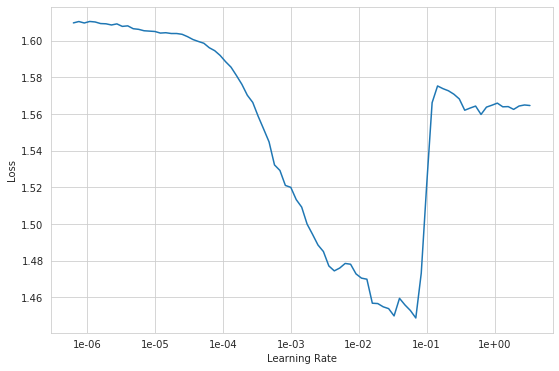

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(5, 1e-4, wd=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.385870,1.222052,0.494333,00:47
1,1.195254,1.156775,0.520000,00:47
2,1.139716,1.122331,0.534000,00:46
3,1.053202,1.089890,0.555000,00:47
4,1.006932,1.085949,0.554667,00:47


## Review

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
interp = learn.interpret()

In [ ]:
cm =interp.confusion_matrix()
# interp.top_losses(k=10)

plt.figure(figsize=(10,8))
plt.grid(False)
plot_confusion_matrix(cm, interp.data.train_ds.y.classes)

In [ ]:
interp.top_losses(20)